In [34]:
import sys
sys.path.append('../')

from stepselector.data_loader import ZebraDataset, ZebraBatchSampler, custom_collate
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
import joblib
from osgeo import gdal
from tqdm.notebook import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier

gdal.UseExceptions()

In [12]:
# Change server_mount for your system
server_mount = '/home/blair/server/herd_hover'
data_folder = os.path.join(server_mount, 'zebra_movement_data')

# Import pre-loaded data
data_file = os.path.join(data_folder, 'loaded_data.csv')
data = pd.read_csv(data_file)
data.drop(labels = ['Unnamed: 0'], axis = 1, inplace = True)
data.rename(columns={'0': 'angle_to_observer',
                     '1': 'dist_to_observer',
                     '2': 'road',
                     '3': 'ground_slope',
                     '4': 'visibility',
                     '5': 'social_dens',
                     '6': 'social_vis'}, inplace = True)

In [14]:
# impute missing values
imputer = SimpleImputer(strategy = 'mean')
df_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
df_imputed = df_imputed.astype({'road': 'int32', 'social_dens':'int32', 'label':'int32'})

In [16]:
# Log-transform distances
df_imputed['log_dist_to_observer'] = np.log1p(df_imputed['dist_to_observer'])

# convert angles to sines and cosines
df_imputed['sin_angle_to_observers'] = np.sin(np.deg2rad(df_imputed['angle_to_observer']))
df_imputed['cos_angle_to_observers'] = np.cos(np.deg2rad(df_imputed['angle_to_observer']))

# drop untransformed columns
df = df_imputed.drop(columns =['dist_to_observer', 'angle_to_observer'])

In [18]:
# initialize scalers
slope_scaler = StandardScaler()
visibility_scaler = MinMaxScaler(feature_range=(0,1))
density_scaler = MinMaxScaler(feature_range=(0,1))
log_distance_scaler = StandardScaler()
sin_cos_scaler = StandardScaler()

In [19]:
# apply scalers
df['ground_slope'] = slope_scaler.fit_transform(df[['ground_slope']])
df['visibility'] = visibility_scaler.fit_transform(df[['visibility']])
df['social_dens'] = density_scaler.fit_transform(df[['social_dens']])
df['social_vis'] = visibility_scaler.fit_transform(df[['social_vis']])
df['log_dist_to_observer'] = log_distance_scaler.fit_transform(df[['log_dist_to_observer']])
df[['sin_angle_to_observers', 'cos_angle_to_observers']] = sin_cos_scaler.fit_transform(df[['sin_angle_to_observers', 'cos_angle_to_observers']])

In [21]:
X = df.drop(columns='label')
y = df['label']

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Initialize and train the logistic regression model with parallelization
model = LogisticRegression(max_iter=1000, n_jobs=1, verbose=True, class_weight = 'balanced', penalty = None, C=1.0)  # n_jobs=-1 uses all available cores
model.fit(X_train, y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.24271D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     12     14      1     0     0   7.325D-05   6.917D-01
  F =  0.69167428196808523     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=1,
                   penalty=None, verbose=True)

In [24]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.52


In [27]:
# check for multicolinnearity 
vif_data = pd.DataFrame()
vif_data['feature'] = df.columns
vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
vif_data

,feature,VIF
0,road,1.040340
1,ground_slope,1.130081
2,visibility,5.192439
3,social_dens,3.770457
4,social_vis,6.620433
5,label,1.171020
6,log_dist_to_observer,1.494856
7,sin_angle_to_observers,1.260283
8,cos_angle_to_observers,1.366675


In [28]:
# Drop social_vis
df_new = df.drop(columns = ['social_vis'])

In [29]:
X = df_new.drop(columns='label')
y = df_new['label']

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Initialize and train the logistic regression model with parallelization
model = LogisticRegression(max_iter=1000, n_jobs=1, verbose=True, class_weight = 'balanced', penalty = None, C=1.0)  # n_jobs=-1 uses all available cores
model.fit(X_train, y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.24271D-02



 This problem is unconstrained.


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=1,
                   penalty=None, verbose=True)

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     15     19      1     0     0   1.457D-05   6.917D-01
  F =  0.69167694039440242     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [32]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.52


In [35]:
# Try with MLPClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

clf = MLPClassifier(random_state=1, max_iter=300, verbose = True, hidden_layer_sizes=(128,128,128)).fit(X_train, y_train)

Iteration 1, loss = 0.46286479
Iteration 2, loss = 0.44927551
Iteration 3, loss = 0.44888213
Iteration 4, loss = 0.44912423
Iteration 5, loss = 0.44814108
Iteration 6, loss = 0.44789657
Iteration 7, loss = 0.44695919
Iteration 8, loss = 0.44766729
Iteration 9, loss = 0.44689352
Iteration 10, loss = 0.44621411
Iteration 11, loss = 0.44569760
Iteration 12, loss = 0.44582813
Iteration 13, loss = 0.44538760
Iteration 14, loss = 0.44532585
Iteration 15, loss = 0.44472185
Iteration 16, loss = 0.44425662
Iteration 17, loss = 0.44379699
Iteration 18, loss = 0.44350174
Iteration 19, loss = 0.44348023
Iteration 20, loss = 0.44348328
Iteration 21, loss = 0.44296063
Iteration 22, loss = 0.44237390
Iteration 23, loss = 0.44184131
Iteration 24, loss = 0.44156798
Iteration 25, loss = 0.44142499
Iteration 26, loss = 0.44204816
Iteration 27, loss = 0.44089897
Iteration 28, loss = 0.44017370
Iteration 29, loss = 0.44008054
Iteration 30, loss = 0.44049182
Iteration 31, loss = 0.43948167
Iteration 32, los

/home/blair/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [36]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.80


In [37]:
# Try dropping nans instead of imputing
data_noNAN = data.dropna()

In [38]:
# Log-transform distances
data_noNAN['log_dist_to_observer'] = np.log1p(data_noNAN['dist_to_observer'])

data_noNAN['sin_angle_to_observers'] = np.sin(np.deg2rad(data_noNAN['angle_to_observer']))
data_noNAN['cos_angle_to_observers'] = np.cos(np.deg2rad(data_noNAN['angle_to_observer']))

# drop untransformed columns
df = data_noNAN.drop(columns =['dist_to_observer', 'angle_to_observer'])

/tmp/ipykernel_41333/843048589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noNAN['log_dist_to_observer'] = np.log1p(data_noNAN['dist_to_observer'])
/tmp/ipykernel_41333/843048589.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noNAN['sin_angle_to_observers'] = np.sin(np.deg2rad(data_noNAN['angle_to_observer']))
/tmp/ipykernel_41333/843048589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [39]:
# apply scalers
df['ground_slope'] = slope_scaler.fit_transform(df[['ground_slope']])
df['visibility'] = visibility_scaler.fit_transform(df[['visibility']])
df['social_dens'] = density_scaler.fit_transform(df[['social_dens']])
df['social_vis'] = visibility_scaler.fit_transform(df[['social_vis']])
df['log_dist_to_observer'] = log_distance_scaler.fit_transform(df[['log_dist_to_observer']])
df[['sin_angle_to_observers', 'cos_angle_to_observers']] = sin_cos_scaler.fit_transform(df[['sin_angle_to_observers', 'cos_angle_to_observers']])

In [40]:
X = df.drop(columns='label')
y = df['label']

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Initialize and train the logistic regression model with parallelization
model = LogisticRegression(max_iter=1000, n_jobs=1, verbose=True, class_weight = 'balanced', penalty = None, C=1.0)  # n_jobs=-1 uses all available cores
model.fit(X_train, y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.71753D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     14     17      1     0     0   3.615D-05   6.910D-01
  F =  0.69096656690986458     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=1,
                   penalty=None, verbose=True)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

In [61]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      5782
           1       0.00      0.00      0.00      1223

    accuracy                           0.83      7005
   macro avg       0.41      0.50      0.45      7005
weighted avg       0.68      0.83      0.75      7005



/home/blair/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/blair/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/blair/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


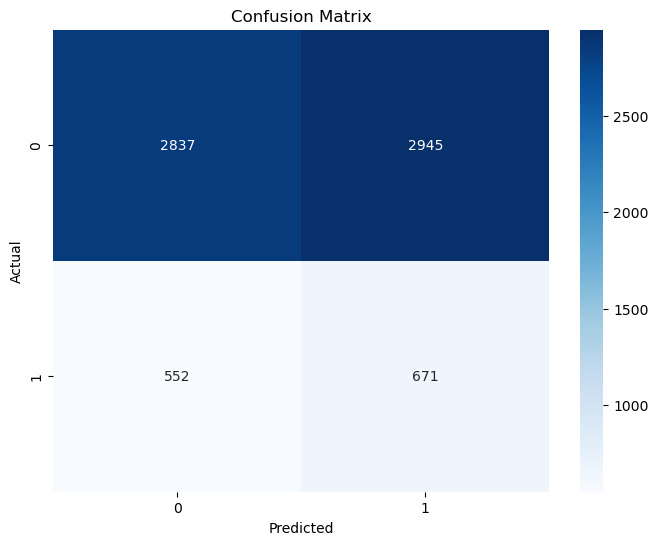

In [56]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [57]:
# Check class distribution
print("Class Distribution in Test Set:")
print(y_test.value_counts())

Class Distribution in Test Set:
label
0    5782
1    1223
Name: count, dtype: int64


In [58]:
# Example: Check coefficients
coefficients = model.coef_
intercept = model.intercept_
print("Model Coefficients:")
print(coefficients)
print("Model Intercept:")
print(intercept)

Model Coefficients:
[[ 0.44135178 -0.25793152 -0.01662978  0.03002811 -0.01182355  0.15832471
   0.016045  ]]
Model Intercept:
[-0.23942122]


In [33]:
df

,0,1,2,3,4,5,6,7,label
0,130.128930,312.373849,0.000000,-4.389323,0.053359,1.000000,0.7,NaN,1
1,NaN,313.353999,NaN,0.000000,NaN,0.051937,1.0,0.7,0
2,NaN,313.278518,NaN,0.000000,NaN,0.052157,1.0,0.7,0
3,NaN,313.087000,NaN,0.000000,NaN,0.052371,1.0,0.7,0
4,NaN,311.517244,NaN,0.000000,NaN,0.054823,2.0,0.7,0
...,...,...,...,...,...,...,...,...,...
35018,142.812766,689.524353,4.122167,0.000000,1.208968,0.063400,10.0,1.0,0
35019,174.669015,690.397101,4.994914,0.000000,1.256004,0.057185,5.0,1.0,0
35020,107.103219,686.911375,1.509188,0.000000,0.782979,0.075386,11.0,1.0,0
35021,145.254185,689.561952,4.159766,0.000000,1.217355,0.062994,9.0,1.0,0


In [67]:
len(fake) - fake.count()

0        270
1          0
2          0
3        270
4          0
5          0
6         20
label      0
dtype: int64

In [37]:
mask = df['label'] == 1
observed = df[mask]
fake = df[~mask]

In [40]:
observed = observed.drop(columns = [7])

In [ ]:
fake = fake.drop(columns = [2])

In [49]:
fake.columns = observed.columns
df_combined = pd.concat([fake, observed], axis=0, ignore_index=True)

In [52]:
X = df_combined.drop(columns='label')
y = df_combined['label']

In [53]:
imputer = SimpleImputer(strategy = 'mean')
newdf_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [54]:
X = newdf_imputed

In [77]:
from sklearn.neural_network import MLPClassifier

In [87]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

clf = MLPClassifier(random_state=1, max_iter=300, verbose = True, hidden_layer_sizes=(128,128,128)).fit(X_train, y_train)

Iteration 1, loss = 1.06943033
Iteration 2, loss = 0.48192034
Iteration 3, loss = 0.48461314
Iteration 4, loss = 0.49563476
Iteration 5, loss = 0.48941917
Iteration 6, loss = 0.46776876
Iteration 7, loss = 0.48114966
Iteration 8, loss = 0.47836182
Iteration 9, loss = 0.47801577
Iteration 10, loss = 0.46401620
Iteration 11, loss = 0.46754833
Iteration 12, loss = 0.47097284
Iteration 13, loss = 0.46266519
Iteration 14, loss = 0.46503740
Iteration 15, loss = 0.46287171
Iteration 16, loss = 0.45908974
Iteration 17, loss = 0.46150014
Iteration 18, loss = 0.45512135
Iteration 19, loss = 0.45668643
Iteration 20, loss = 0.45527578
Iteration 21, loss = 0.45792511
Iteration 22, loss = 0.45634696
Iteration 23, loss = 0.45374668
Iteration 24, loss = 0.45373725
Iteration 25, loss = 0.45253528
Iteration 26, loss = 0.45325306
Iteration 27, loss = 0.45208668
Iteration 28, loss = 0.45123760
Iteration 29, loss = 0.45119288
Iteration 30, loss = 0.45145895
Iteration 31, loss = 0.45165866
Iteration 32, los

In [88]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.83


In [89]:
clf.score(X_test, y_test)

0.8332571950662403

In [90]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      7296
           1       0.00      0.00      0.00      1460

    accuracy                           0.83      8756
   macro avg       0.42      0.50      0.45      8756
weighted avg       0.69      0.83      0.76      8756



/home/blair/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/blair/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/blair/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


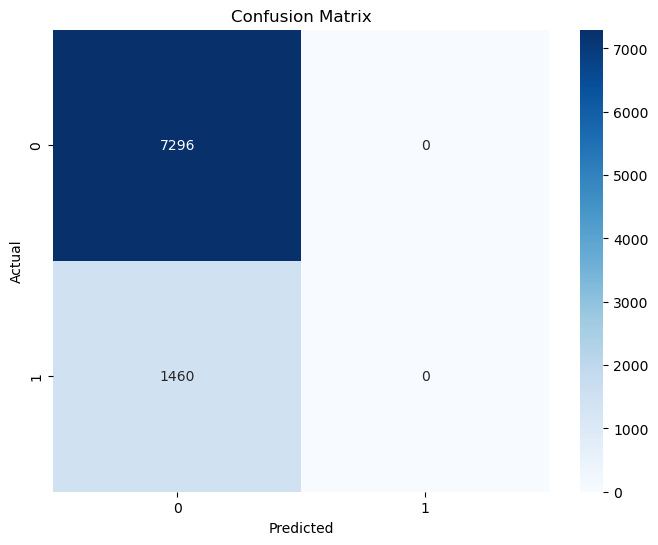

In [91]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [59]:
# Check class distribution
print("Class Distribution in Test Set:")
print(y_test.value_counts())

Class Distribution in Test Set:
label
0    5782
1    1223
Name: count, dtype: int64


In [ ]:
# features = []
# labels = []

# # Iterate over data loader
# for batch in tqdm(dataloader):
#     # Extract target and reference data
#     target, references = batch

#     # Extract features for target point and label as 1
#     target_data = target[0]
#     target_features = [
#         target_data['angle_to_observers'],
#         target_data['dist_to_observer'],
#         target_data['road'],
#         target_data['ground_slope'],
#         target_data['visibility'],
#         target_data['social_dens'],
#         target_data['social_vis']
#     ]
#     features.append(target_features)
#     labels.append(1)

#     for ref in references[0]:
#         ref_features = [
#             ref['angle_to_observers'],
#             ref['dist_to_observer'],
#             ref['delta_observer_dist'],
#             ref['road'],
#             ref['ground_slope'],
#             ref['visibility'],
#             ref['social_dens'],
#             ref['social_vis']
#         ]
#         features.append(ref_features)
#         labels.append(0)

# # Convert to numpy arrays
# features = np.array(features)
# labels = np.array(labels)

# # Handle missing values (nan) by imputing with the mean of the column
# imputer = SimpleImputer(strategy = 'mean')
# features = imputer.fit_transform(features)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state=42)

# # Initialize and train the logistic regression model
# model = LogisticRegression(max_iter = 1000)
# model.fit(X_train, y_train)

/home/blair/.local/lib/python3.10/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [ ]:
#y_pred = model.predict(X_test)

In [ ]:
#

In [ ]:
#accuracy

In [ ]:
#accuracy

In [ ]:
#joblib.dump(model, '/home/blair/fine-scale-movement/logistic_regression_model.joblib')